In [1]:
import pandas as pd
import os, sys
sys.path.append("..")
from utils.getfund import data_operator
import pandas as pd
from utils.operatefund import Operator, User
from models.models import db_operator
from utils.readconfig import config
import datetime
from multiprocessing import Process, Queue, Pool
# from strategies.fixed import Strategy
# exec("from strategies.{} import Strategy".format(config["strategy_file"]))
from concurrent.futures import ThreadPoolExecutor
from strategies.fixed import Strategy
import datetime
import cupy as cp
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

------------------ F:\Projects\pricepredictor\data\db\MyFund.db
------------- sqlite:///F:\Projects\pricepredictor\data\db\MyFund.db?check_same_thread=False
2020-07-12 02:46:25,570 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-07-12 02:46:25,571 INFO sqlalchemy.engine.base.Engine ()
2020-07-12 02:46:25,571 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-07-12 02:46:25,572 INFO sqlalchemy.engine.base.Engine ()
2020-07-12 02:46:25,573 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Fund")
2020-07-12 02:46:25,574 INFO sqlalchemy.engine.base.Engine ()
2020-07-12 02:46:25,575 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Record")
2020-07-12 02:46:25,576 INFO sqlalchemy.engine.base.Engine ()
2020-07-12 02:46:25,577 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("User")
2020-07-12 02:46:25,577 INFO sqlalchemy.engine.base.Engine ()
2020-07-12 02:46:25,578

In [2]:
fund_list_all = data_operator.get_funds_list("F:\\Projects\\pricepredictor\\data\\fund_data\\all_fund.csv")
fund_code_list = fund_list_all.ID.values
fd_data = data_operator.load_funds(fund_code_list)
print(len(fd_data.sort_values(by="date")))

6123682


In [3]:
# select the funds with 8 years' history.
# fund with long history means more stability.
long_fd_list = fd_data[fd_data.date>datetime.datetime(2020,2,1)].fund_code.unique()
long_fd_list1 = fd_data[fd_data.date<datetime.datetime(2012,2,1)].fund_code.unique()
long_fd_list

array(['000001', '000003', '000004', ..., '519953', '519955', '007115'],
      dtype=object)

In [4]:
import numpy as np
len(long_fd_list)
len(long_fd_list1)
len(np.intersect1d(long_fd_list,long_fd_list1))
long_fd_list = np.intersect1d(long_fd_list,long_fd_list1)
print(len(long_fd_list))
long_fd_list[100:200]

709


array(['092002', '096001', '100020', '100022', '100026', '100032',
       '100037', '100038', '100039', '100050', '100051', '100053',
       '100055', '100056', '100058', '110001', '110002', '110003',
       '110005', '110007', '110008', '110009', '110011', '110012',
       '110013', '110015', '110017', '110018', '110019', '110020',
       '110021', '110022', '110023', '110026', '110028', '110035',
       '110036', '112002', '121001', '121002', '121003', '121005',
       '121006', '121008', '121009', '121012', '128112', '151001',
       '151002', '160105', '160119', '160121', '160123', '160124',
       '160125', '160211', '160212', '160213', '160215', '160217',
       '160311', '160314', '160513', '160514', '160603', '160605',
       '160607', '160610', '160611', '160612', '160613', '160615',
       '160616', '160617', '160618', '160706', '160716', '160717',
       '160718', '160719', '160805', '160806', '160807', '160808',
       '160910', '161005', '161010', '161014', '161015', '1611

In [5]:
# take '110013' as example
class code_config(object):
    target_code = '110013'
    train_dur = [datetime.date(2012,3,1), datetime.date(2016,3,1)]
    test_dur = [datetime.date(2016,3,2), datetime.date(2017,3,2)]

target_fund = fd_data[fd_data.fund_code==code_config.target_code]
target_fund.isna()

,fund_code,date,price,accumulate,daily_rate,purchase_state,ransom_state,dividends
124,False,False,False,False,False,False,False,False
835,False,False,False,False,False,False,False,False
1548,False,False,False,False,False,False,False,False
2260,False,False,False,False,False,False,False,False
2981,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
6095079,False,False,False,False,False,False,False,False
6102148,False,False,False,False,False,False,False,False
6108822,False,False,False,False,False,False,False,False
6115420,False,False,False,False,False,False,False,False


In [6]:
# make sure missed value inside.
# for most fund, default is processed/filterred when scrapping
target_fund[target_fund.isna().values==False]
for x in target_fund.columns:
    print(target_fund[x][target_fund[x].isna()==True],'missed')

Series([], Name: fund_code, dtype: object) missed
Series([], Name: date, dtype: datetime64[ns]) missed
Series([], Name: price, dtype: float64) missed
Series([], Name: accumulate, dtype: float64) missed
Series([], Name: daily_rate, dtype: float64) missed
Series([], Name: purchase_state, dtype: object) missed
Series([], Name: ransom_state, dtype: object) missed
Series([], Name: dividends, dtype: object) missed


In [7]:
# analyzing features
# fund_date could be cut into seasons (Q1, Q2, Q3, Q4)
# numeric type: price, accumulate, daily_rate
# category type: purchase_state, ransom_state, dividends
target_fund.head(10)

,fund_code,date,price,accumulate,daily_rate,purchase_state,ransom_state,dividends
124,110013,2012-01-31,1.050,5.009,0.0086,开放申购,开放赎回,
835,110013,2012-02-01,1.040,4.996,-0.0095,开放申购,开放赎回,
1548,110013,2012-02-02,1.056,5.017,0.0154,开放申购,开放赎回,
2260,110013,2012-02-03,1.065,5.029,0.0085,开放申购,开放赎回,
2981,110013,2012-02-06,1.057,5.018,-0.0075,开放申购,开放赎回,
3692,110013,2012-02-07,1.042,4.998,-0.0142,开放申购,开放赎回,
4403,110013,2012-02-08,1.063,5.026,0.0202,开放申购,开放赎回,
5114,110013,2012-02-09,1.075,5.042,0.0113,开放申购,开放赎回,
5826,110013,2012-02-10,1.088,5.060,0.0121,开放申购,开放赎回,
6547,110013,2012-02-13,1.074,5.041,-0.0129,开放申购,开放赎回,


In [8]:
# for numeric types
target_fund.describe()

,price,accumulate,daily_rate
count,2060.000000,2060.000000,2060.000000
mean,2.099930,6.729024,0.000969
std,0.740384,1.189568,0.016686
min,0.991000,4.930000,-0.076300
25%,1.314750,5.431750,-0.007300
50%,2.245000,7.014500,0.000900
75%,2.620250,7.562250,0.009700
max,4.369000,10.196000,0.069300


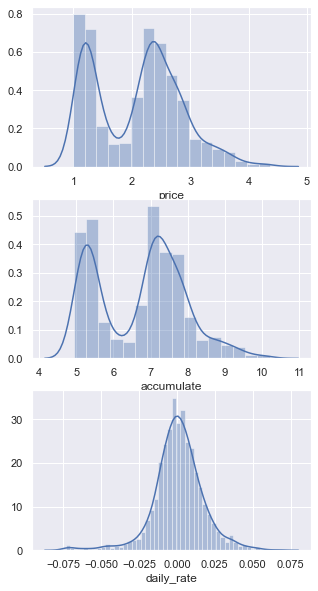

In [9]:
# check the distribution
sns.set(style='darkgrid')
plt.figure(figsize=(5,10))
plt.subplot(3,1,1)
sns.distplot(target_fund['price'])
plt.subplot(312)
sns.distplot(target_fund['accumulate'])
plt.subplot(313)
sns.distplot(target_fund['daily_rate'])
# it seems that daily_rate is obeying the normal distribution.

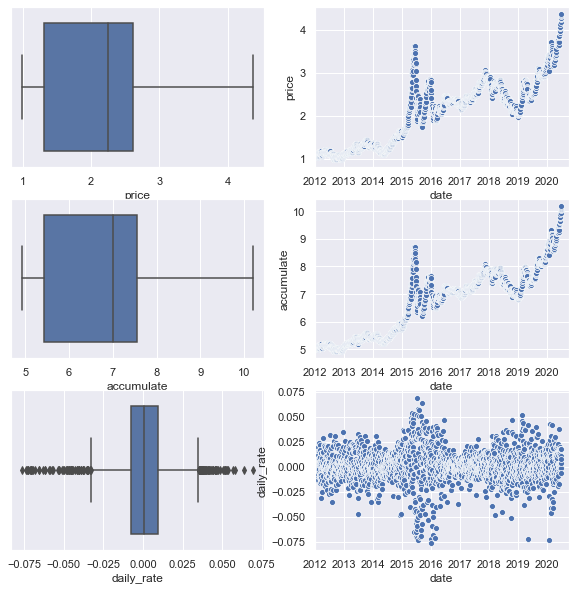

In [96]:
# about extreme values
sns.set(style='darkgrid')
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
sns.boxplot(target_fund['price'])
plt.subplot(323)
sns.boxplot(target_fund['accumulate'])
plt.subplot(325)
sns.boxplot(target_fund['daily_rate'])
ax = plt.subplot(322)
ax.set_xlim([datetime.datetime(2012,1,1),datetime.datetime(2020,10,1)])
sns.scatterplot(data = target_fund, x='date', y='price')
ax = plt.subplot(324)
ax.set_xlim([datetime.datetime(2012,1,1),datetime.datetime(2020,10,1)])
sns.scatterplot(data = target_fund, x = 'date', y='accumulate')
ax = plt.subplot(326)
ax.set_xlim([datetime.datetime(2012,1,1),datetime.datetime(2020,10,1)])
sns.scatterplot(data = target_fund, x = 'date', y='daily_rate')
# extreme value is not ridiculious. no need to cut.

In [11]:
# for category variables, check all types
print(target_fund.purchase_state.unique(),'# purchase_state','\n')
print(target_fund.ransom_state.unique(),'# ransom_state','\n')
print(target_fund.dividends.unique(),'# dividends','\n' )
# ransom --> only one type, no need
# purchase_state --> turn to one-hot(0/1)
# dividends --> contains number, and need to turn to value

# turn dividends to numbers

['开放申购' '限制大额申购'] # purchase_state 

['开放赎回'] # ransom_state 

['' '每份派现金0.0400元' '每份派现金0.0600元' '每份派现金0.0800元' '每份派现金0.1040元'
 '每份派现金0.1170元' '每份派现金0.0100元'] # dividends 



In [74]:
# start to feature engineering
# data preprocessing
# turn index to date
# delete ransom_state (fixed data)
raw_target_data = target_fund
raw_target_data.set_index(raw_target_data.date, inplace=True)
raw_target_data = raw_target_data[['price','accumulate','daily_rate','purchase_state','dividends']]
raw_target_data

,price,accumulate,daily_rate,purchase_state,dividends
date,,,,,
2012-01-31,1.050,5.009,0.0086,开放申购,
2012-02-01,1.040,4.996,-0.0095,开放申购,
2012-02-02,1.056,5.017,0.0154,开放申购,
2012-02-03,1.065,5.029,0.0085,开放申购,
2012-02-06,1.057,5.018,-0.0075,开放申购,
...,...,...,...,...,...
2020-06-29,4.269,10.062,-0.0009,开放申购,
2020-06-30,4.345,10.164,0.0178,开放申购,
2020-07-01,4.318,10.127,-0.0062,开放申购,


In [76]:
# extract price to 
# turn time to quarter: month->quarter
# Q1->[1,2,3], Q2->[4,5,6], Q3->[7,8,9], Q4->[10,11,12]
import math
timemap = {i:math.ceil(i/3) for i in range(1,13)}
raw_target_data["quarter"] = raw_target_data.apply(lambda x: timemap[x.name.month], axis=1)
raw_target_data

,price,accumulate,daily_rate,purchase_state,dividends,quarter
date,,,,,,
2012-01-31,1.050,5.009,0.0086,开放申购,,1
2012-02-01,1.040,4.996,-0.0095,开放申购,,1
2012-02-02,1.056,5.017,0.0154,开放申购,,1
2012-02-03,1.065,5.029,0.0085,开放申购,,1
2012-02-06,1.057,5.018,-0.0075,开放申购,,1
...,...,...,...,...,...,...
2020-06-29,4.269,10.062,-0.0009,开放申购,,2
2020-06-30,4.345,10.164,0.0178,开放申购,,2
2020-07-01,4.318,10.127,-0.0062,开放申购,,3


In [77]:
# extract numeric data from [dividends]
raw_target_data.dividends = pd.to_numeric(raw_target_data['dividends'].apply(lambda x: x[5:-1])).fillna(0)
raw_target_data

,price,accumulate,daily_rate,purchase_state,dividends,quarter
date,,,,,,
2012-01-31,1.050,5.009,0.0086,开放申购,0.0,1
2012-02-01,1.040,4.996,-0.0095,开放申购,0.0,1
2012-02-02,1.056,5.017,0.0154,开放申购,0.0,1
2012-02-03,1.065,5.029,0.0085,开放申购,0.0,1
2012-02-06,1.057,5.018,-0.0075,开放申购,0.0,1
...,...,...,...,...,...,...
2020-06-29,4.269,10.062,-0.0009,开放申购,0.0,2
2020-06-30,4.345,10.164,0.0178,开放申购,0.0,2
2020-07-01,4.318,10.127,-0.0062,开放申购,0.0,3


In [78]:
# transform [purchase_state] and [quarter] to one-hot
purchase_state_map = {'开放申购':1, '限制大额申购':2}
raw_target_data['purchase_state']=raw_target_data['purchase_state'].apply(lambda x: purchase_state_map[x])
new_target_data = pd.get_dummies(raw_target_data, columns=['purchase_state', 'quarter'])
new_target_data

,price,accumulate,daily_rate,dividends,purchase_state_1,purchase_state_2,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,
2012-01-31,1.050,5.009,0.0086,0.0,1,0,1,0,0,0
2012-02-01,1.040,4.996,-0.0095,0.0,1,0,1,0,0,0
2012-02-02,1.056,5.017,0.0154,0.0,1,0,1,0,0,0
2012-02-03,1.065,5.029,0.0085,0.0,1,0,1,0,0,0
2012-02-06,1.057,5.018,-0.0075,0.0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-06-29,4.269,10.062,-0.0009,0.0,1,0,0,1,0,0
2020-06-30,4.345,10.164,0.0178,0.0,1,0,0,1,0,0
2020-07-01,4.318,10.127,-0.0062,0.0,1,0,0,0,1,0


In [79]:
raw_target_data = new_target_data
raw_target_data

,price,accumulate,daily_rate,dividends,purchase_state_1,purchase_state_2,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,
2012-01-31,1.050,5.009,0.0086,0.0,1,0,1,0,0,0
2012-02-01,1.040,4.996,-0.0095,0.0,1,0,1,0,0,0
2012-02-02,1.056,5.017,0.0154,0.0,1,0,1,0,0,0
2012-02-03,1.065,5.029,0.0085,0.0,1,0,1,0,0,0
2012-02-06,1.057,5.018,-0.0075,0.0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-06-29,4.269,10.062,-0.0009,0.0,1,0,0,1,0,0
2020-06-30,4.345,10.164,0.0178,0.0,1,0,0,1,0,0
2020-07-01,4.318,10.127,-0.0062,0.0,1,0,0,0,1,0


In [80]:
# Normalization of the price, accumulate, daily_rate, dividends.
# z-score + MaxMinScaler

def CustomEncoder(df=raw_target_data, columns=['price', 'accumulate','daily_rate','dividends']):
    scalers = dict()
    scalers['stand'] = dict()
    scalers['minmax'] = dict()
    temps = df[columns].copy()
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    for col in columns:
        scalers['stand'][col] = StandardScaler()
        scalers['minmax'][col] = MinMaxScaler()
        scalers['stand'][col].fit(df[[col]])
        temps[col] = scalers['stand'][col].transform(df[[col]])
        scalers['minmax'][col].fit(temps[[col]])
        temps[col] = scalers['minmax'][col].transform(temps[[col]])
    return temps[columns], scalers

        
def CustomDecoder(df, columns, scalers):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    temps = df[columns].copy()
    for col in columns:
        temps[col] = scalers['minmax'][col].inverse_transform(df[[col]])
        temps[col] = scalers['stand'][col].inverse_transform(temps[[col]])
    return temps

# test the custom encoder and custom decoder.
temp = raw_target_data.copy()
print(temp[['price', 'accumulate','daily_rate','dividends']],'\n # before encode')
temp[['price', 'accumulate','daily_rate','dividends']], scalers = CustomEncoder(temp,columns=['price', 'accumulate','daily_rate','dividends'])
print(temp,"\n # after encode")
temp[['price', 'accumulate','daily_rate','dividends']] = CustomDecoder(temp,columns = ['price', 'accumulate','daily_rate','dividends'],scalers=scalers)
print(temp[['price', 'accumulate','daily_rate','dividends']], '\n # after decode')

price  accumulate  daily_rate  dividends
date                                                
2012-01-31  1.050       5.009      0.0086        0.0
2012-02-01  1.040       4.996     -0.0095        0.0
2012-02-02  1.056       5.017      0.0154        0.0
2012-02-03  1.065       5.029      0.0085        0.0
2012-02-06  1.057       5.018     -0.0075        0.0
...           ...         ...         ...        ...
2020-06-29  4.269      10.062     -0.0009        0.0
2020-06-30  4.345      10.164      0.0178        0.0
2020-07-01  4.318      10.127     -0.0062        0.0
2020-07-02  4.334      10.149      0.0037        0.0
2020-07-03  4.369      10.196      0.0081        0.0

[2060 rows x 4 columns] 
 # before encode
               price  accumulate  daily_rate  dividends  purchase_state_1  \
date                                                                        
2012-01-31  0.017466    0.015002    0.583104        0.0                 1   
2012-02-01  0.014506    0.012533    0.458791     

In [81]:
# Normalization of raw_target_data
raw_target_data[['price', 'accumulate','daily_rate','dividends']], custom_scalers = CustomEncoder()

In [82]:
raw_target_data

,price,accumulate,daily_rate,dividends,purchase_state_1,purchase_state_2,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,
2012-01-31,0.017466,0.015002,0.583104,0.0,1,0,1,0,0,0
2012-02-01,0.014506,0.012533,0.458791,0.0,1,0,1,0,0,0
2012-02-02,0.019242,0.016521,0.629808,0.0,1,0,1,0,0,0
2012-02-03,0.021906,0.018800,0.582418,0.0,1,0,1,0,0,0
2012-02-06,0.019538,0.016711,0.472527,0.0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-06-29,0.970397,0.974554,0.517857,0.0,1,0,0,1,0,0
2020-06-30,0.992895,0.993923,0.646291,0.0,1,0,0,1,0,0
2020-07-01,0.984902,0.986897,0.481456,0.0,1,0,0,0,1,0


In [93]:
# training data & verification data & test data
# input: timestep=30, features=[price	accumulate	daily_rate	dividends	purchase_state_1	purchase_state_2	quarter_1	quarter_2	quarter_3	quarter_4], output = [price] of 5 days later.
# train set: 2012-3-1-->2017-3-1
# verification set: 2017-3-1-->2018-3-1
# test set: 2018-3-1-->2020-3-1
raw_target_data['y'] = raw_target_data['price'].shift(5)
train_data = raw_target_data.loc['2012-03-01':'2017-03-01']
verify_data = raw_target_data.loc['2017-3-1':'2018-3-1']
test_data = raw_target_data.loc['2018-3-1':'2020-3-1']
test_data

,price,accumulate,daily_rate,dividends,purchase_state_1,purchase_state_2,quarter_1,quarter_2,quarter_3,quarter_4,y
date,,,,,,,,,,,
2018-03-01,0.492895,0.528295,0.610577,0.0,1,0,1,0,0,0,0.462996
2018-03-02,0.489047,0.525066,0.490385,0.0,1,0,1,0,0,0,0.461516
2018-03-05,0.496744,0.531713,0.591346,0.0,1,0,1,0,0,0,0.478390
2018-03-06,0.505329,0.539119,0.598901,0.0,1,0,1,0,0,0,0.480462
2018-03-07,0.500888,0.535131,0.485577,0.0,1,0,1,0,0,0,0.483126
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-24,0.808467,0.835359,0.640110,0.0,1,0,1,0,0,0,0.758733
2020-02-25,0.806986,0.834030,0.515110,0.0,1,0,1,0,0,0,0.768502
2020-02-26,0.761397,0.794911,0.239698,0.0,1,0,1,0,0,0,0.761989
